
# REBEL

In [1]:
from transformers import pipeline
import textwrap
import networkx as nx
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import matplotlib.pyplot as plt

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON

def get_dbpedia_abstract(resource_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    
    # Query to fetch the abstract of a resource from DBpedia
    query = f"""
    SELECT ?abstract
    WHERE {{
        <http://dbpedia.org/resource/{resource_name}> dbo:abstract ?abstract .
        FILTER (langMatches(lang(?abstract), 'en'))
    }}
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    try:
        results = sparql.query().convert()
        abstracts = results["results"]["bindings"]
        
        if abstracts:
            return abstracts[0]["abstract"]["value"]
        else:
            return "Abstract not found for the resource."
    except Exception as e:
        return f"Error: {str(e)}"

resource_name = "Captain_America:_The_First_Avenger"
abstract = get_dbpedia_abstract(resource_name)
print(abstract)

Captain America: The First Avenger is a 2011 American superhero film based on the Marvel Comics character Captain America. Produced by Marvel Studios and distributed by Paramount Pictures, it is the fifth film in the Marvel Cinematic Universe (MCU). The film was directed by Joe Johnston, written by Christopher Markus and Stephen McFeely, and stars Chris Evans as Steve Rogers / Captain America alongside Tommy Lee Jones, Hugo Weaving, Hayley Atwell, Sebastian Stan, Dominic Cooper, Toby Jones, Neal McDonough, Derek Luke, and Stanley Tucci. During World War II, Steve Rogers, a frail man, is transformed into the super-soldier Captain America and must stop the Red Skull (Weaving) from using the Tesseract as an energy source for world domination. The film began as a concept in 1997 and was scheduled for distribution by Artisan Entertainment. However, a lawsuit disrupted the project and was not settled until September 2003. In 2005, Marvel Studios received a loan from Merrill Lynch, and planne

In [3]:
resume = "Captain America: The First Avenger is a 2011 superhero film, based on the Marvel Comics superhero of the same name. It is the fifth film in the Marvel Cinematic Universe, and the fifth installment of Phase One. The film was released on July 22, 2011, in the United States and on July 29, 2011, internationally.The film is directed by Joe Johnston and stars Chris Evans as Steve Rogers/Captain America, Tommy Lee Jones as Chester Phillips, Hugo Weaving as Johann Schmidt/Red Skull, Hayley Atwell as Peggy Carter, Sebastian Stan as Bucky Barnes, Dominic Cooper as Howard Stark, Neal McDonough as Dum Dum Dugan, Derek Luke as Gabe Jones, and Stanley Tucci as Abraham Erskine.The film spawned three sequels: Captain America: The Winter Soldier in 2014, Captain America: Civil War in 2016, and Captain America: Brave New World, slated to release in 2025."
resume = resume.replace('/',' or ')

In [4]:
l = []
base = 0
for i in range(0,len(resume),100):
    l.append(resume[base: base+i])
    base = i
    print(resume[base: base+i])

#print(l)


 the same name. It is the fifth film in the Marvel Cinematic Universe, and the fifth installment of 
Phase One. The film was released on July 22, 2011, in the United States and on July 29, 2011, internationally.The film is directed by Joe Johnston and stars Chris Evans as Steve Rogers or Captain Amer
ationally.The film is directed by Joe Johnston and stars Chris Evans as Steve Rogers or Captain America, Tommy Lee Jones as Chester Phillips, Hugo Weaving as Johann Schmidt or Red Skull, Hayley Atwell as Peggy Carter, Sebastian Stan as Bucky Barnes, Dominic Cooper as Howard Stark, Neal McDonough as 
ica, Tommy Lee Jones as Chester Phillips, Hugo Weaving as Johann Schmidt or Red Skull, Hayley Atwell as Peggy Carter, Sebastian Stan as Bucky Barnes, Dominic Cooper as Howard Stark, Neal McDonough as Dum Dum Dugan, Derek Luke as Gabe Jones, and Stanley Tucci as Abraham Erskine.The film spawned three sequels: Captain America: The Winter Soldier in 2014, Captain America: Civil War in 2016, and C

In [5]:
history = "It is 1942, America has entered World War II, and sickly but determined Steve Rogers is frustrated at being rejected yet again for military service. Everything changes when Dr. Erskine recruits him for the secret Project Rebirth. Proving his extraordinary courage, wits and conscience, Rogers undergoes the experiment and his weak body is suddenly enhanced into the maximum human potential. When Dr. Erskine is then immediately assassinated by an agent of Nazi Germany's secret HYDRA research department (headed by Johann Schmidt, a.k.a. the Red Skull), Rogers is left as a unique man who is initially misused as a propaganda mascot; however, when his comrades need him, Rogers goes on a successful adventure that truly makes him Captain America, and his war against Schmidt begins."

In [6]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [8]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [82]:
def from_text_to_kb(text, span_length=126, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")
    
    print(inputs)

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [78]:
total = f"{resume} {history}"
print((len(total))/120)

13.65


In [83]:
kb = from_text_to_kb(f"{resume} {history}", verbose=True)
kb.print()

{'input_ids': tensor([[    0, 35645,   730,    35,    20,  1234, 44985,    16,    10,  1466,
         15257,   822,     6,   716,    15,     5,  8714, 28018, 15257,     9,
             5,   276,   766,     4,    85,    16,     5,  1998,   822,    11,
             5,  8714, 23488,  5183, 15384,     6,     8,     5,  1998, 18513,
             9, 11028,   509,     4,    20,   822,    21,   703,    15,   550,
           820,     6,  1466,     6,    11,     5,   315,   532,     8,    15,
           550,  1132,     6,  1466,     6,  9275,     4,   133,   822,    16,
          3660,    30,  2101, 13870,     8,  2690,  1573,  4869,    25,  2206,
          7541,    50,  8977,   730,     6,  8880,  2094,  1454,    25, 12813,
          7431,     6, 18148,   166, 13286,    25, 34688, 13128,    50,  1211,
         39481,     6,  6280,   607,   497,  3056,    25, 26733,  5306,     6,
         11740,  8995,    25,   163, 19873, 10164,     6, 14036,  5097,    25,
          5218, 19772,     6, 15454,  

In [84]:
G = nx.DiGraph()

relation = {}
k = 0
for i, elem in enumerate(kb.relations):
    if elem['tail'] not in relation:
        relation[elem['tail']] = k
        G.add_node(k, name = relation[elem['tail']])
        k += 1
        
    if elem['head'] not in relation:
        relation[elem['head']] = k
        G.add_node(k, name=elem['head'])
        k += 1

    G.add_edge(relation[elem['head']], relation[elem['tail']], name = elem['type'])

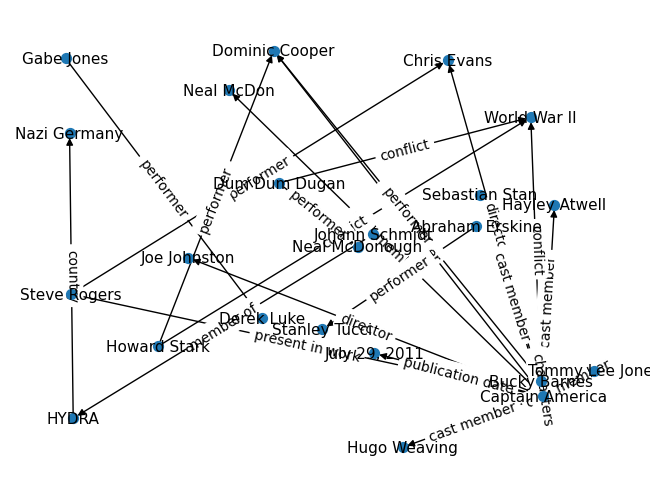

In [85]:
inv_map = {v: k for k, v in relation.items()}
pos = nx.random_layout(G)
edge_labels = dict([((n1, n2), d['name'])
                    for n1, n2, d in G.edges(data=True)])

options = {
    'labels':inv_map,
    'with_labels':True,
    'node_size': 50,
    'pos': pos,
    'font_size':11
}

nx.draw(G, **options)
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
plt.show()

In [90]:
from rdflib import Graph, Literal, Namespace
from rdflib import RDF

g = Graph()
ns = Namespace("http://projet.fr/text/")

In [91]:
for node in G.nodes():
    name = inv_map.get(node)
    
    try:
        head = datetime.strptime(date_str, '%m-%d-%Y').date()
    except:     
        head = name.replace(' ','_').replace("'",'_').replace(',','_')
    #g.add((ns[head], ns.name, Literal(node)))
    
        g.add((ns[head], ns["name"], Literal(name)))
        g.add((ns[head], RDF.type, ns['Node']))  # Example mapping node to RDF type 'Node'

In [92]:
for edge in G.edges(data=True):
    print(edge)
    
    source, target, data = edge
    source = inv_map.get(source).replace(' ','_').replace("'",'_').replace(',','_')
    name = inv_map.get(target)
    target = name.replace(' ','_').replace("'",'_').replace(',','_')
        
        
    property = data['name'].replace(" ","_")
    
    if 'date' in property:
        g.add((ns[source], ns[property], Literal(name)))
    else:
        if property != 'director' and property != 'name':
            g.add((ns[source], ns[property], ns[target]))

(1, 0, {'name': 'director'})
(1, 2, {'name': 'director'})
(1, 3, {'name': 'cast member'})
(1, 4, {'name': 'cast member'})
(1, 5, {'name': 'cast member'})
(1, 6, {'name': 'cast member'})
(1, 7, {'name': 'characters'})
(1, 8, {'name': 'cast member'})
(1, 9, {'name': 'cast member'})
(1, 10, {'name': 'publication date'})
(7, 8, {'name': 'performer'})
(7, 19, {'name': 'conflict'})
(11, 1, {'name': 'present in work'})
(11, 2, {'name': 'performer'})
(12, 8, {'name': 'performer'})
(12, 19, {'name': 'conflict'})
(14, 13, {'name': 'performer'})
(14, 19, {'name': 'conflict'})
(16, 15, {'name': 'performer'})
(18, 17, {'name': 'performer'})
(20, 22, {'name': 'country'})
(21, 20, {'name': 'member of'})


In [93]:
g.serialize(destination="extracted_text.ttl", format="turtle")

<Graph identifier=Nfa4f8e33734a47389752958413b10adc (<class 'rdflib.graph.Graph'>)>